<a href="https://drive.google.com/file/d/1gq_zxRNQ6ebT5HhSiaCPqZPM6Uya4g5u/view?usp=sharing" target="_blank" >
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD;
    color: black;"> <strong><font color="#A41034">LSSDS: DCGANs on MNIST</font></strong></h1>


**Summer 2024**<br/>
**Instructor:**Pavlos Protopapas<br/>
**Authors:** Arya Mohan, Lakshay Chawla

<hr style="height:2pt">


In this lab, we will generate handwritten numbers using DCGANs on the MNIST dataset.

[Here](https://arxiv.org/pdf/1511.06434v1.pdf) is the paper if you are interested!

Here are the main features of DCGAN:

- Use convolutions without any pooling layers
- Use batchnorm in both the generator and the discriminator
- Don't use fully connected hidden layers
- Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation
- Use LeakyReLU activation in the discriminator for all layers except or the output

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importing necessary libraries
import time
import numpy as np
import tensorflow as tf
from tqdm.auto import tqdm
from keras.datasets import mnist
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from keras.layers import Dense, Activation, Flatten, Reshape, Conv2D, Conv2DTranspose, UpSampling2D, Input

## Download and Prepare the Dataset

In [ ]:
# Function for visualizing generated images
# n: Number of images to show
# G: Generator Model
def show_samples(n, G):
    noise = tf.random.normal(shape=(n, latent_dim))
    imgs = G.predict_on_batch(noise)
    fig, ax = plt.subplots(1, n, figsize=(6, 8))
    for i in range(n):
        ax[i].imshow(np.clip(imgs[i].reshape(28,28), 0.0, 1.0), cmap='gray')
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
latent_dim = 100
batch_size = 256
img_rows, img_cols = 28, 28
img_channels = 1

# Downloading MNIST dataset
(x_train, _), (_, _) = mnist.load_data()

# Reshape and normalize all images to [-1, 1]
# Your code here

In [ ]:
# Divide the dataset into batches for training
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size//2,drop_remainder=True)
print(f'Number of batches: {len(list(train_dataset.as_numpy_iterator()))}')
print(f'Batch size: {list(train_dataset.as_numpy_iterator())[0].shape}')

Number of batches: 468
Batch size: (128, 28, 28, 1)


## Define the generator

You will build a generator using 4 layers (3 hidden layers + 1 output layer). Write a function to define the generator's neural network.

Remember to use ReLU activation for every layer and tanh activation for the output layer.


In [ ]:
def generator_model():
    depth = 128
    dim = 7

    # In: 100
    # Out: dim x dim x depth
    # use BatchNormalization with momentum=0.9 and stride = 1 for first 2 layers and 2 for the last two
    # Padding = 'same'
    # Convolution of size 5
    # your code here

    return model

## Define the discriminator

The second model you need to create is the discriminator.

You will use 4 layers in your discriminator's neural network.

In [ ]:
def discriminator_model():
    depth = 32
    dropout = 0.3
    input_shape = (img_rows, img_cols, img_channels)

    # In: 28 x 28 x 1, depth = 1
    # use LeakyRELU with alpha=0.2
    # use stride 2 for all layers
    # Convolution of size 5
    # your code here

    return model

In [ ]:
g_model = ____
d_model = ____

## Losses or Optimizers

In [ ]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
# Discriminator Loss
def discriminator_loss(real_output, fake_output):
    real_loss = bce_loss(tf.ones_like(real_output), real_output)
    fake_loss = bce_loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(d_predictions):
    return bce_loss(tf.ones_like(d_predictions), d_predictions)

Define adam optimizer with `lr=0.0002` for discriminator and `lr=0.002` for generator.

In [ ]:
d_optimizer = ____
g_optimizer = ____

## Training

Define your training loop by iterating through the number of epochs and the batches of real data generated before.

Remember, the training loop begins with generator receiving 100-D noise as input. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

Define `train_step` function that trains the generator and discriminator over a batch

In [ ]:
# Compiles the train_step function into a callable TensorFlow graph
# Also speeds up the training time
@tf.function
def train_step(dataset):

    real_images = dataset
    real_labels = np.ones((batch_size//2,1))
    random_latent_vectors = tf.random.normal(shape=(batch_size//2, latent_dim))
    generated_images = g_model(random_latent_vectors)

    # Train the discriminator.
    with tf.GradientTape() as tape:
        pred_fake = d_model(generated_images)
        pred_real = d_model(real_images)

        d_loss = discriminator_loss(pred_real, pred_fake)

    grads = tape.gradient(d_loss, d_model.trainable_variables)
    d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))

    #-----------------------------------------------------------------#

    # Sample random points in the latent space.
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        fake_images = g_model(random_latent_vectors)
        predictions = d_model(fake_images)
        g_loss = generator_loss(predictions)

    grads = tape.gradient(g_loss, g_model.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables))

    return d_loss, g_loss

Define a `train` function that uses `train_step` to train on the entire dataset for `n` epochs.

In [ ]:
def train(dataset, epochs=10):
    for epoch in tqdm(range(epochs)):

        # Define lists for discriinator loss and generator loss
        # Make a loop to go through the entire dataset and leverages train_step to train a batch
        # Print images and losses after every epoch
        # your code here

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

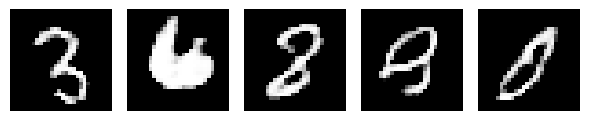

Epoch: 1 -- Generator Loss: 0.832001805305481, Discriminator Loss: 1.3142833709716797

Took 5.728587865829468 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

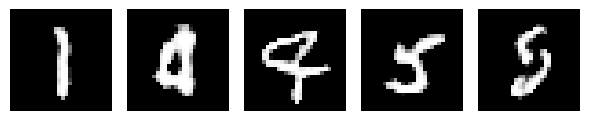

Epoch: 2 -- Generator Loss: 0.8541976809501648, Discriminator Loss: 1.2997102737426758

Took 5.917900085449219 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

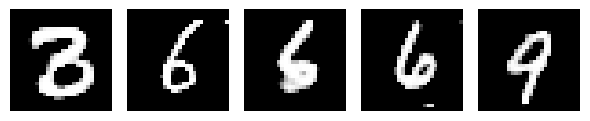

Epoch: 3 -- Generator Loss: 0.8905957937240601, Discriminator Loss: 1.2748209238052368

Took 5.763774156570435 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

2024-08-21 14:17:32.875703: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


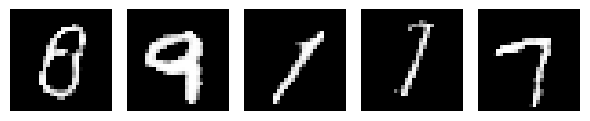

Epoch: 4 -- Generator Loss: 0.9342670440673828, Discriminator Loss: 1.2334098815917969

Took 5.67760968208313 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

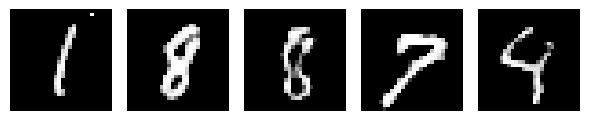

Epoch: 5 -- Generator Loss: 0.9767096042633057, Discriminator Loss: 1.2010107040405273

Took 5.687516927719116 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

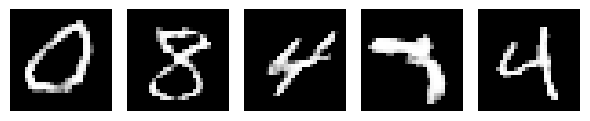

Epoch: 6 -- Generator Loss: 1.013169765472412, Discriminator Loss: 1.1776888370513916

Took 5.6831746101379395 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

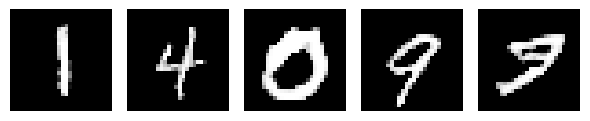

Epoch: 7 -- Generator Loss: 1.0517910718917847, Discriminator Loss: 1.1455296277999878

Took 5.6898884773254395 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

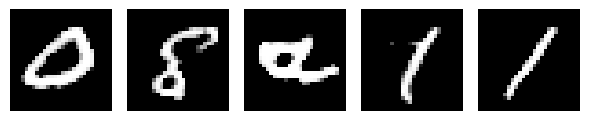

Epoch: 8 -- Generator Loss: 1.0946600437164307, Discriminator Loss: 1.1137745380401611

Took 5.701903581619263 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

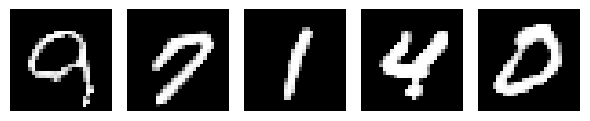

Epoch: 9 -- Generator Loss: 1.1192686557769775, Discriminator Loss: 1.0991069078445435

Took 5.700362682342529 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

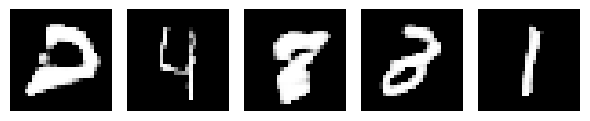

Epoch: 10 -- Generator Loss: 1.1652451753616333, Discriminator Loss: 1.0744260549545288

Took 5.707117080688477 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

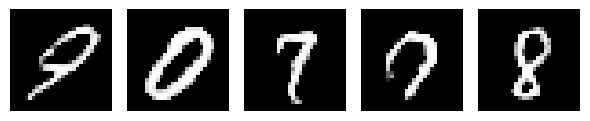

Epoch: 11 -- Generator Loss: 1.1985580921173096, Discriminator Loss: 1.0544986724853516

Took 5.719645261764526 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

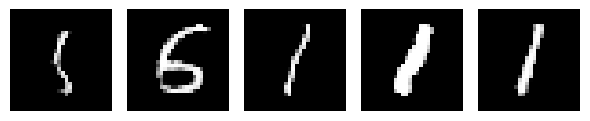

Epoch: 12 -- Generator Loss: 1.2260262966156006, Discriminator Loss: 1.0405911207199097

Took 5.702946901321411 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

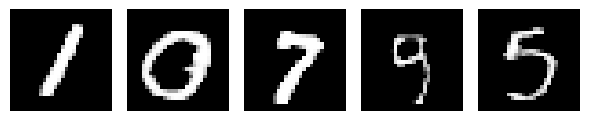

Epoch: 13 -- Generator Loss: 1.2485263347625732, Discriminator Loss: 1.0189695358276367

Took 5.713293790817261 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

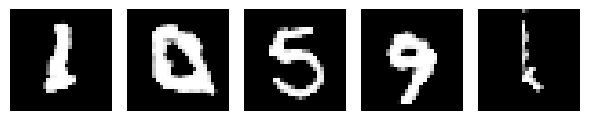

Epoch: 14 -- Generator Loss: 1.2794660329818726, Discriminator Loss: 0.9986463785171509

Took 5.709347486495972 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

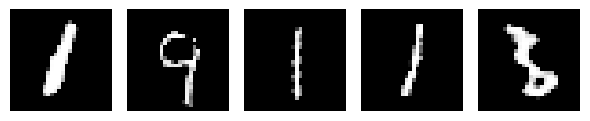

Epoch: 15 -- Generator Loss: 1.304471492767334, Discriminator Loss: 0.9894663691520691

Took 5.708915710449219 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

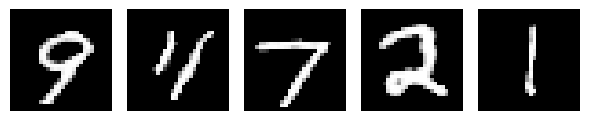

Epoch: 16 -- Generator Loss: 1.3222037553787231, Discriminator Loss: 0.9751079082489014

Took 5.8683998584747314 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

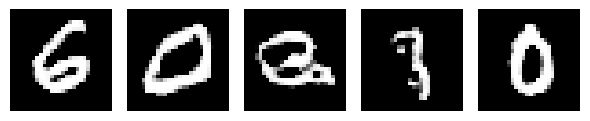

Epoch: 17 -- Generator Loss: 1.3569732904434204, Discriminator Loss: 0.9524015784263611

Took 5.602041006088257 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

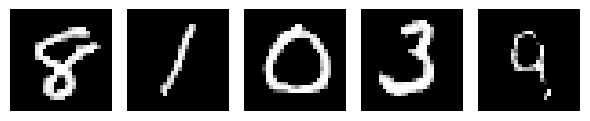

Epoch: 18 -- Generator Loss: 1.3769806623458862, Discriminator Loss: 0.9400188326835632

Took 5.558157920837402 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

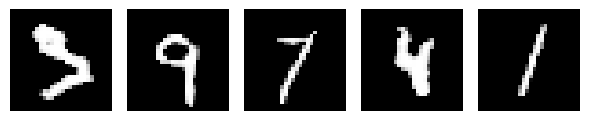

Epoch: 19 -- Generator Loss: 1.4049243927001953, Discriminator Loss: 0.9365524053573608

Took 5.601800918579102 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

2024-08-21 14:19:04.030612: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


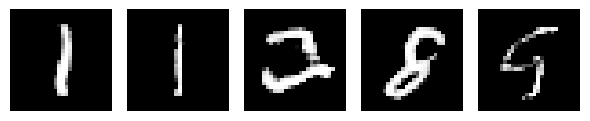

Epoch: 20 -- Generator Loss: 1.4361978769302368, Discriminator Loss: 0.9115642309188843

Took 5.782128095626831 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

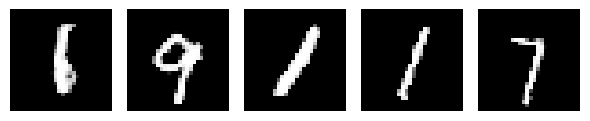

Epoch: 21 -- Generator Loss: 1.4530227184295654, Discriminator Loss: 0.9010432362556458

Took 5.770369291305542 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

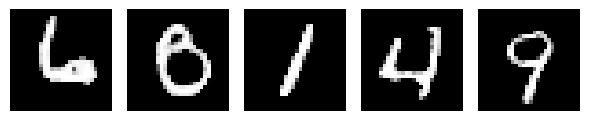

Epoch: 22 -- Generator Loss: 1.480888843536377, Discriminator Loss: 0.8898069858551025

Took 5.8364622592926025 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

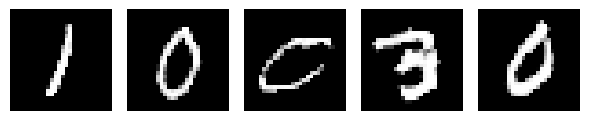

Epoch: 23 -- Generator Loss: 1.4959732294082642, Discriminator Loss: 0.8800575137138367

Took 5.764889240264893 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

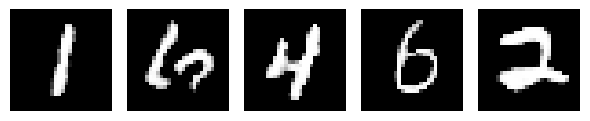

Epoch: 24 -- Generator Loss: 1.5261026620864868, Discriminator Loss: 0.8645603656768799

Took 5.796325445175171 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

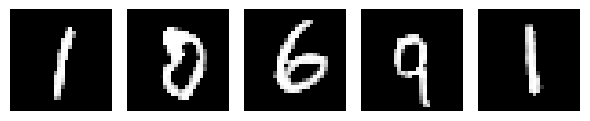

Epoch: 25 -- Generator Loss: 1.5449414253234863, Discriminator Loss: 0.8599326610565186

Took 5.807405471801758 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

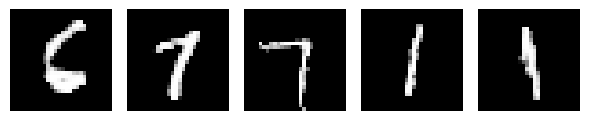

Epoch: 26 -- Generator Loss: 1.576339602470398, Discriminator Loss: 0.8401402235031128

Took 5.732848644256592 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

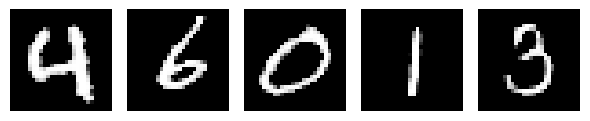

Epoch: 27 -- Generator Loss: 1.5974295139312744, Discriminator Loss: 0.8238095045089722

Took 5.859308242797852 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

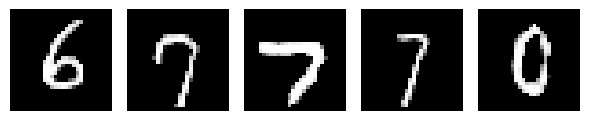

Epoch: 28 -- Generator Loss: 1.6260340213775635, Discriminator Loss: 0.8187415599822998

Took 5.710475206375122 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

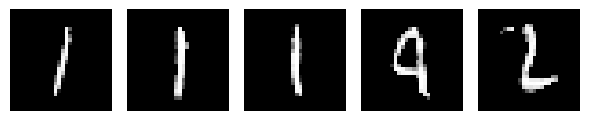

Epoch: 29 -- Generator Loss: 1.6513155698776245, Discriminator Loss: 0.8120000958442688

Took 5.8205602169036865 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

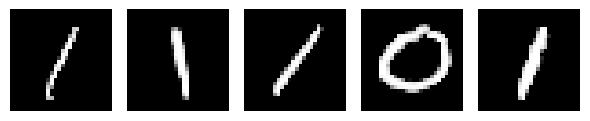

Epoch: 30 -- Generator Loss: 1.6737366914749146, Discriminator Loss: 0.8008514046669006

Took 5.89852237701416 seconds. 




In [ ]:
# Train the DCGAN for 20-30 epochs
____